# Week 5 - Expectation Maximization and Principal Component Analysis

Learning contents:

1. Mixture of Gaussians: Expectation-Maximization
    - Display results
    - Nearest Centroid-based classification
2. Principal Component Analysis
    - Generate data
    - Apply PCA
    - Display projection

## Dependencies

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal, norm
from sklearn import datasets
from IPython.display import HTML

import seaborn as sns; sns.set(); sns.set_palette('bright')


###         Tips jeg har lært 
#  x = np.zeroes(150).reshape(-1, 1) => x.shape = (150,)  -> x.shape(150,1). Så kan numpy rent faktisk lave matrix multiplikationer, som man regner at den gør. 
# np.sum(x in R^150x2) -> [[sum[:, 0] + sum[:, 1]], [sum[:, 0] + sum[:, 1]]]
# np.sum(x in R^150x2, axis = 0) -> [[sum[:, 0]], sum[:, 1]]


## Generate Data

#### We use `iris` dataset from `sklearn` library

(<matplotlib.collections.PathCollection at 0x116aa7d70>,
 <matplotlib.legend.Legend at 0x114fea8d0>)

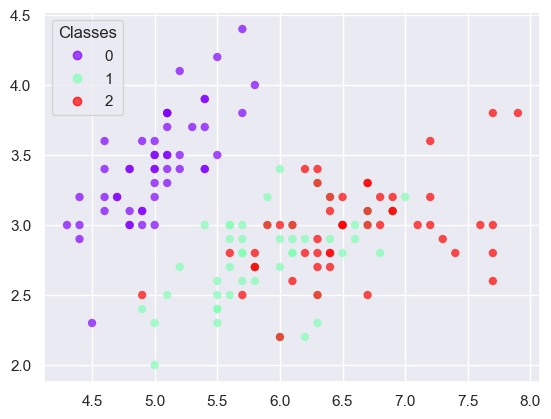

In [178]:
iris = datasets.load_iris()
iris_x = np.array(iris.data[:, :2])  # we only take the first two features.
iris_t = np.array(iris.target)

def plot_iris(legend=True, classes=iris_t, target=plt):
    scatter = target.scatter(iris_x[:, 0], iris_x[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

plot_iris()

## 1) Mixture of Gaussians: Expectation-Maximization

write a function `gaussian_mixture` that takes data point `x` (say, a vector in D-dimensional space), set of multivariate `means` and respective `covariances`, and `pis` (mixing coefficients as defined in a Gaussian mixture model) and should return PDF value of mixture model at the point x.

In [179]:
def gaussian_mixture(x, means, covariances, pis):
    pdfx = np.sum([pis[k] * multivariate_normal.pdf(x = x, mean = means[k], cov = covariances[k]) for k in range(len(means))], axis=0)
    return pdfx



write a function `expectation_maximization_gaussian` that takes initial mean vectors `mus_0`, initial covariance matrices `covariances_0`, initial mixing coefficient values `pis_0`, input data set `data_x` and a callback `on_step`. See Slide 14 of Lecture 9.

The `on_step` is a function that takes current set of `mus`, corresponding `covariances` and `pis`, value of `log_likelihood` and list of class `predictions` for each point and should be called each iteration step. Remember that you do not need to define this function as it has already been defined in the later part of the code, you just need to call it after updating parameters in each iteration.

In [180]:
def expectation_maximization_gaussian(mus_0, covariances_0, pis_0, data_x, on_step):
    # Evaluation
    # So the evaluation acts as an average of the k'th object with xn over all the K objects. 
    # The denorminator is exactly what I just did in previous function. 
    # The length K do I determine from the length of means.
    # The length of N do I determine from the length of datapoints x. 
    
    N, D = data_x.shape # Datapoints and dimension of x
    K = len(mus_0)
    gamma = np.zeros((N, K))
    for n in range(N): 
        denominator = gaussian_mixture(data_x[n], mus_0, covariances_0, pis_0)
        xn = data_x[n]
        
        # Gamma(znk)
        for k in range(K): 
            gamma[n, k] = (pis_0[k]/denominator) * multivariate_normal.pdf(x = xn, mean=mus_0[k], cov=covariances_0[k])
        
            
    # Now for reestimating     
    mean_new = np.zeros(mus_0.shape)
    cov_new = np.zeros(covariances_0.shape)
    pis_new = np.zeros(pis_0.shape)
    
    # Functions: 
    meank = lambda Nk, gamma, x : (1/Nk) * np.sum(gamma[:, k].reshape(-1, 1) * x[:], axis = 0)
    covk = lambda Nk, gamma, xn, mean_new : (1/Nk) * gamma[n, k] * np.outer(xn - mean_new,(xn - mean_new).T)       
    for k in range(K): 
        Nk = np.sum(gamma[:, k]) # Nk = np.sum(n=1 -> N (gammaznk in R^150x3))    => sum = [sum_k1, sum_k2, sum_k3] = np.sum(gamma[:, k]), iterating over every k
        mean_new[k] = meank(Nk, gamma, data_x)
        for n in range(N): 
            cov_new[k] += covk(Nk, gamma, data_x[n], mean_new[k])     
        pis_new[k] = Nk/N
      
        
    # Evaluation: 
    # The logLikeliHood is just the sum over the natural logarithm to the gaussian mixture. It's the exact same as the denominator in gamma. 
    logLikeliHood = lambda pis, x, mean, cov : np.sum([
        np.log(
            np.sum([pis[k] * multivariate_normal.pdf(x[n], mean[k], cov[k]) 
                    for k in range(K)])) 
        for n in range(N)])
    
    # I haven't been given a exact criteria on when to stop, so make me do it when |logLikeliHoodk - logLikeliHoodk-1| < 0.00001
    criteria = 0.00001
    logLikeliHoodk_1 = logLikeliHood(pis =   pis_0, x = data_x, mean =    mus_0, cov = covariances_0)
    logLikeliHoodk =   logLikeliHood(pis = pis_new, x = data_x, mean = mean_new, cov =       cov_new)
    
    # Appending data before checking criteria. 
    predictions = np.argmax(gamma, axis=1) # gamma in R^150x3, for every n which of the columns is highest? The column index == k therefore this gives me k. 
    on_step(mean_new, cov_new, pis_new, logLikeliHoodk, predictions)
    
    if np.abs(logLikeliHoodk - logLikeliHoodk_1) < criteria: 
        return
    else : 
        expectation_maximization_gaussian(mus_0=mean_new, covariances_0=cov_new, pis_0=pis_new, data_x=data_x, on_step=on_step)     
       

### 1.1) Display results

In [181]:
def plot_gaussian_mixtures(mus, covariances, pis, data, classes, cmap='rainbow', target=plt):
    
    lx = min(data[:, 0])
    rx = max(data[:, 0])
    by = min(data[:, 1])
    uy = max(data[:, 1])

    x, y = np.mgrid[lx:rx:.01, by:uy:.01]
    pos = np.dstack((x, y))
    
    probabilities = list(map(
        lambda x: gaussian_mixture(x, mus, covariances, pis),
        pos
    ))
    
    target.contour(x, y, probabilities, cmap=cmap)
    
    plot = plot_iris(classes=classes, target=target)
    # scatter = target.scatter(mus[:, 0], mus[:, 1], c=[0, 1, 2], cmap='rainbow', marker='data', s=300, edgecolors='black')
    return (*plot, )


def plot_mesh(pred_fn, n_class=3, x_min=4, x_max=8, y_min=2, y_max=4.5, target=plt):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = np.array(list(map(lambda x: pred_fn(np.array(x)), np.c_[xx.ravel(), yy.ravel()])))
    Z = Z.reshape(xx.shape)
    cs = target.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    target.axis('tight')
    if hasattr(target, 'xlim'):
        target.xlim(x_min, x_max)
        target.ylim(y_min, y_max)

Here, we define our initial means `mus_0`, covariance matrices `covariances_0`, mixing coefficient values `pis_0` and call the `expectation_maximization_gaussian function`

In [182]:
np.random.seed(26)

classes = 3

all_steps_em = []

mus_0 = iris_x[:classes]
covariances_0 = np.array([np.cov(iris_x.T)] * classes)
pis_0 = np.array([1/classes] * classes)

expectation_maximization_gaussian(
    mus_0, covariances_0, pis_0, iris_x,
    lambda mus, covs, pis, log_likelihood, predictions: all_steps_em.append((mus, covs, pis, log_likelihood, predictions))
)
print(len(all_steps_em))
 #print(all_steps_em[0])
# print("\n\n\n\n\n")
#print(all_steps_em[17])

47


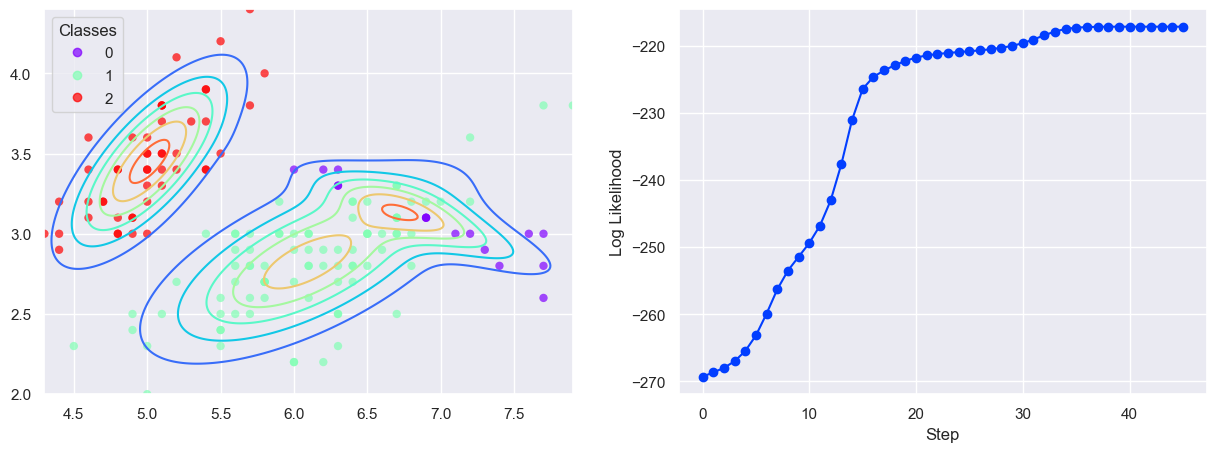

In [183]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
                
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x)

### 1.2) Nearest Centroid-based classification

Write the `nearest_centroid_based_class` that takes (a possibly D-dimensional) data point `x`, a set of (a possibly D-dimensional) means `mus` and (a set of DxD dimensional) `covariances` and returns the predicted class of this data point based on nearest centroid based classification. See slide 17-23 of lecture 9.

In [184]:
def nearest_centroid_based_class(x, mus, covariances):
    singleVariable = x.ndim == 1
    K = mus.shape[0]
    N = x.shape[0] if singleVariable else x.shape[0][0]
    distance = np.zeros((N, K))
    
    if singleVariable: 
        for k in range(K):
            distance[:, k] = x - mus[k][0] # x values distance
        classification = np.argmin(np.abs(distance), axis = 1)
        return classification
    
    
        
    for k in range(K):
        distance[:, k] = x - mus[k]
    dist_norm = np.linalg.norm(distance, axis=1) # axis 1 is over each dimension. √(distx^2 + disty^2 + ... + distd^2)
    classification = np.argmin(dist_norm, axis = 1) # axis 1 such that it decides which of the indices of k clusters is closest. 
    #                                              k is the same as indices here. 
    return classification

ValueError: cannot reshape array of size 2000 into shape (25,40)

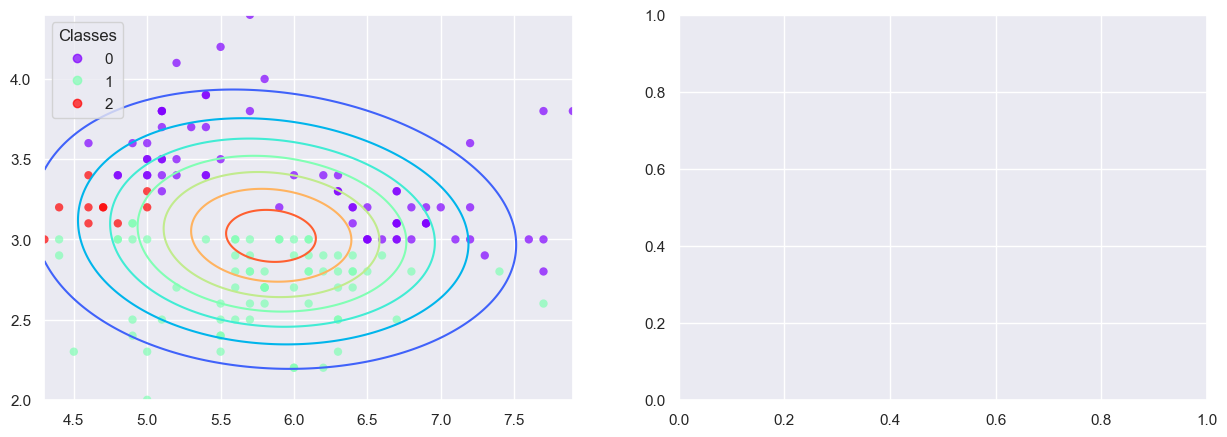

In [185]:
def create_animation(all_steps_em, data_x):
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    log_likelihoods = list(map(lambda x: x[3], all_steps_em))
    
    def animate(i):
        ax.cla()
        ax2.cla()
        
        predictions = all_steps_em[i][4]
        
        plot1 = plot_gaussian_mixtures(all_steps_em[i][0], all_steps_em[i][1], all_steps_em[i][2], iris_x, predictions, target=ax)
        
        plot_mesh(
            lambda x: nearest_centroid_based_class(x, all_steps_em[i][0], all_steps_em[i][1]),
            n_class=len(all_steps_em[i][0]), target=ax
        )
        
        ax2.plot(list(range(i)), log_likelihoods[:i], '-o')
        plt.xlabel('Step')
        plt.ylabel('Log Likelihood')
        return plot1
    
    anim = FuncAnimation(
        fig, animate,
        frames=len(all_steps_em), interval=500, blit=True
    )
    return HTML(anim.to_html5_video())

create_animation(all_steps_em, iris_x)

## 2) Principal Component Analysis

### 2.1) Generate data

In [172]:
iris4_x = np.array(iris.data[:, :4])

def plot_classes_3d(data, classes):

    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=-150, azim=110)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=classes,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    plt.show()
plot_classes_3d(iris4_x[:, :3], iris_t)

<Figure size 800x600 with 0 Axes>

### 2.3) Apply PCA

write a function `pca_projection` that takes input data points `data`, desired number of `components` as arguments and returns the PCA projection of the `data`. See the lecture slides 10.

In [174]:
def pca_projection(data, components):
    N, D = data.shape;      M = components
    # So I've gotten some variables, that I will have to find on my own.
    mean = np.mean(data, axis = 0) # Mean for every dimension. 
    cov = np.zeros((D, D))
    for n in range(N): 
        cov += (1/N) * np.outer(data[n] - mean,(data[n] - mean).T) 
    eigVals, eigVec = np.linalg.eig(cov)
    # I've found in the about page of numpys eigenvectors, that they are found as the columns returned. 
    # A little counter intuitive, but I found it before i used them.
    # I now need to find the biggest eigVals, and sort the eigvecs by their respective size of eigenvalues.
    # indices = np.argmax(eigVals)
    indices = np.argsort(eigVals) # Argsort sorts for lowest values, and returns the corresponding indices of the sorted array. 
    indices = np.flip(indices) # Flip then reverses the array, making it be sorted from lowest to highest, till highest to lowest. 
    
    # eigvals[i] corresponds to eigVectors[:, i]
    U = eigVec[:, indices[:M]]
        # Ulen = np.linalg.norm(U, axis = 0) # length of eigenvecs
        #                   - Eigenvec are by default normalized. 
    
    # x in R^150x4 . U in R^4xM => R ^ 150xM
    
    # In regards to calculations this means that an x @ U operations : c_12 : data x1 on vector u2 like so: 
    # x[1, 0] * U[0, 1] + 
    # x[1, 1] * U[1, 1] + 
    # x[1, 2] * U[2, 1] + 
    # x[1, 3] * U[3, 1]
    # So this is a dot operations on every point in the dataset with the u different u vectors. 
    # That now makes more sense, why the eigvecs are shaped like they are. 
    
    xU = data @ U # xU[1, :] length of datapoint 1 projected onto m vector of total size M 
    # This is then my reduced x data of lengths of x onto u. 
    # These are scalars and when dotted onto the direction of u, 
    # these will give the coordinates of the projected x in coordinatesystem of D. 
    # Thus reconstructing a N x D matrix, ruining the purpose we tried to make. 
    
    # But say I wanted to do that, for unpacking purposes, when the data has been transfered, I could then do the inverse like. 
    # x = xU @ U.T
    
    
    
    
    # But I won't. Here's the projection 
    return xU 
    
projected_data = pca_projection(iris4_x, 2)

### 2.4) Display projection

(<matplotlib.collections.PathCollection at 0x116d3f830>,
 <matplotlib.legend.Legend at 0x114c348c0>)

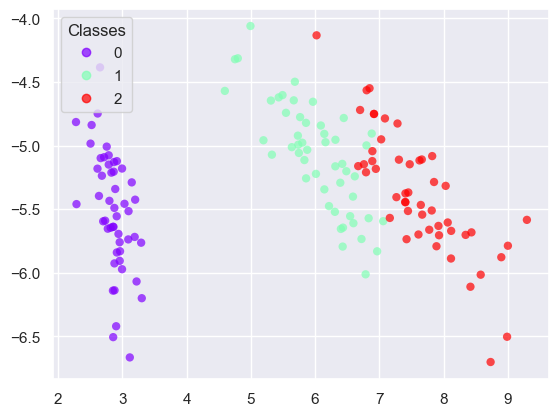

In [175]:
def plot_classes(data, classes, legend=True, target=plt):
    scatter = target.scatter(data[:, 0], data[:, 1], c=classes, alpha=0.7, cmap='rainbow', edgecolor='none')
    if legend:
        legend = target.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
        return (scatter, legend)
    return (scatter, )

projected_data = pca_projection(iris4_x, 2)
plot_classes(projected_data, iris_t)
# Some precision has been lost in the process, but it's kindda like the data we started with. 

In [176]:
projected_data = pca_projection(iris4_x, 3)